# Trial for own CNN w/ pixel-targeting


based on Base_Model_03.ipynb
----

Step 1 : detect tiles with trees using expanded tiles for prediction
Step 2 : get pixel location of trees using coordinate-regression on expanded tiles

In [1]:
import random
import numpy as np

import json
import matplotlib.pyplot as plt
from tqdm import tqdm as tq
import matplotlib.patches as patches

import tensorflow as tf
from keras import models, layers, optimizers, losses, metrics
from keras.utils import load_img
from keras.utils import img_to_array
import autokeras as ak

2022-06-11 00:03:22.878631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-11 00:03:22.878656: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


-------------------------
# Import data

----


## Loading the Image

In [2]:
# Data sources
path_raw_data = 'Potsdam_v02_small/'
name_raw_data = 'Potsdam02s'
raw_image_number = 0
tile_size = 25 # in pixel
border = 15 # in pixel per side --> expands small tile to large tile
batch_size = 300
history_list = {}

## Loading the label-points for the picture from label studio

There are (1383,) labeled trees in the picture


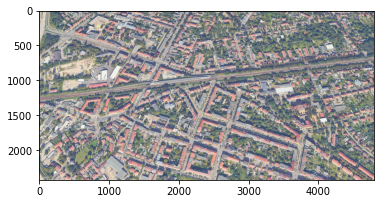

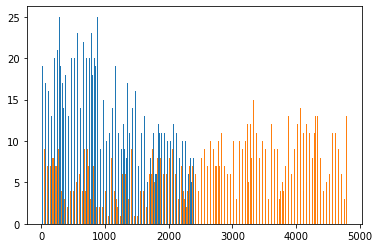

The image size is 2427x4800 pixels.
The 1383 data points are distributed along the respective axis as follows:


In [5]:
def import_image(path_raw_data, name_raw_data, raw_image_number):

    # load the image to get its shape
    orig_image = load_img(path_raw_data+name_raw_data+'.jpg')
    i_width, i_height = orig_image.size

    # convert to numpy array
    image = img_to_array(orig_image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # load the label-points for the picture from label studio
    with open(path_raw_data+name_raw_data+'.json') as json_file:
        json_load = json.load(json_file)

    # select data
    json_load = json_load[raw_image_number]["annotations"][0]["result"]
    labels_x = ([])
    labels_y = ([])
    for i in json_load:
            labels_x = np.append(labels_x, i["value"]["x"])
            labels_y = np.append(labels_y, i["value"]["y"])
    labels_unscaled = np.vstack((labels_y, labels_x)).transpose()

    # scale data points to image pixels
    reshaper = [[(i_height/100), 0], [0,(i_width/100)]]
    labels = np.mat(labels_unscaled) * np.mat(reshaper)
    print(f"There are {labels_unscaled[:,0].shape} labeled trees in the picture")

    # show image
    plt.imshow(orig_image)
    plt.show()
    plt.close()
    # check label distribution in histogram
    plt.hist((labels), bins=200)
    plt.show()
    print(f"The image size is {i_height}x{i_width} pixels.")
    print(f"The {len(labels_x)} data points are distributed along the respective axis as follows:")

    # add row for dedicated tile
    labels = labels.astype('int')
    labels = np.hstack((labels, 0*labels[:,0]))

    return image, labels, orig_image, labels_unscaled, i_width, i_height

image, labels, orig_image, labels_unscaled, i_width, i_height = import_image(path_raw_data, name_raw_data, raw_image_number)

Matching Image and labels and show upload result

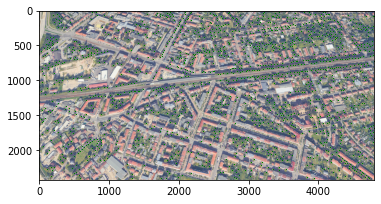

In [4]:
def show_img_with_labels(image=orig_image, labels=labels, marker=','):
    plt.imshow(image)
    # plot each labeled tree
    for dot in labels:
        #print(dot[:,1])
        plt.plot(dot[:,1], dot[:,0], marker=marker, color="green")
    # show the plot
    plt.show()

show_img_with_labels()

## Prepare tiles

EXPANING TILES

Tiles = child-pictures of image, all together represent the whole image (about twice)
- split the picture into quadratic tiles of equal size
- add second split of the picture into quadratic tiles of equal size
- tiles of different layers are stacked on top of each other shiftet by half the tile size

In [7]:
def make_tiles_small(image=image, i_width=i_width, i_height=i_height, tile_size=tile_size, border=border):

    # prepare variables for both tile layers
    ## rounded down to full tiles ignoring the last tile if it is not full:
    num_hor = int((i_width - 2 * border) // tile_size)
    num_ver = int((i_height - 2 * border) // tile_size)
    num_tiles = num_hor * num_ver
    print(f"There are {num_tiles} small tiles at {tile_size}x{tile_size} pixels")
    print(f"Small tiles identified: {num_ver} X {num_hor} tiles")

    # prepare variables for the tiles
    image = np.array(image) # input image
    tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images

    # initiate info variables
    ## store information about the tiles in total and in each layer:
    tile_dims = (num_tiles, num_ver, num_hor)
    tile_info_initial = np.zeros((num_tiles, 8)) # store information about the tiles
    ## tile_info:
        ### (tile row, tile column, true_label, probability,
        ### position horizontal, position vertical  // (top left corner of tile in the image)
        ### vertical label position, horizontal label position within the (small) tile

    # create tiles
    for i in range(num_ver):
        for j in range(num_hor):
            tile_num = i * num_hor + j
            # give starting (left/top) & mean pixels in rows and columns for this tile
            v_start = border + i * tile_size
            h_start = border + j * tile_size
            # create tile
            tile = image[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
            # add tile to array
            tiles[tile_num] = tile
            # store location ot tiles:
            tile_info_initial[tile_num] = (i,j,0,0,v_start, h_start, 0, 0)

    print(f"Tiles are created: {tiles.shape}.")
    return tiles, tile_info_initial, tile_dims

tiles, tile_info_initial, tile_dims = make_tiles_small()

There are 18050 small tiles at 25x25 pixels
Small tiles identified: 95 X 190 tiles
Tiles are created: (18050, 25, 25, 3).


Labels vector is created over all tiles: (18050, 1).
Tiles labeled as with tree: 1325.0
This is 7.340720221606649% of the tiles.
Total trees assigned: 1334.0.
The max number of trees per tile is: 2.0
Distribution trees per tile:


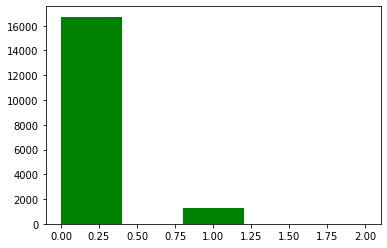

In [114]:
def label_tiles(labels=labels, tile_info_initial=tile_info_initial, tile_size=tile_size, tile_dims=tile_dims, border=border):

    # prepare variables
    num_tiles = tile_dims[0]
    max_v = int(tile_size * tile_dims[1] - 2 * border)
    max_h = int(tile_size * tile_dims[2] - 2 * border)
    tile_labels = np.zeros((num_tiles, 1)) # labels for each tile: 0 = no tree, 1 = tree
    tile_dense = np.zeros((num_tiles, 1)) # number of trees in each tile = density of a tile
    tile_info = tile_info_initial

    # Labeling the tiles
    for label in labels:
        # ignore if out of image range
        l_v = label[:,0]
        l_h = label[:,1]

        if (l_v<=max_v and l_v>border) and (l_h<=max_h and l_h>border):
            # find the tile that contains the label
            ## step through horizontal tiles alternating between layers
            pos_vertical = (l_v - border) // tile_size  # position in vertical direction
            pos_horizontal = (l_h - border) // tile_size  # position in horizontal direction
            tile_num = int((pos_vertical * tile_dims[2]) + pos_horizontal)

            # update arrays
            tile_labels[tile_num] = 1
            tile_dense[tile_num] += 1
            tile_info[tile_num][2] = 1
            tile_info[tile_num][6] = l_v - tile_info[tile_num][4]
            tile_info[tile_num][7] = l_h - tile_info[tile_num][5]
            label[:,2] = tile_num

    # print info on input labels
    print(f"Labels vector is created over all tiles: {tile_labels.shape}.")
    print(f"Tiles labeled as with tree: {tile_labels.sum()}")
    print(f"This is {tile_labels.sum()/tile_labels.shape[0]*100}% of the tiles.")
    print(f"Total trees assigned: {tile_dense.sum()}.")

    # show label distribution amongst tiles
    print(f"The max number of trees per tile is: {tile_dense.max()}")
    plt.hist(tile_dense, bins=5, color="green")
    print("Distribution trees per tile:")
    plt.show()
    plt.close()

    return tile_info, tile_labels

tile_info, tile_labels = label_tiles()

In [9]:
def expand_tiles(tile_info=tile_info, tile_dims=tile_dims, border=border, image=image):

    image = np.array(image) # input image
    tile_size_large = tile_size + 2 * border
    tiles_large = np.zeros((tile_dims[0], tile_size_large, tile_size_large, 3))

    for tile in range(tile_dims[0]):
        v_start = int(tile_info[tile, 4] - border)
        h_start = int(tile_info[tile, 5] - border)
        tile_large = image[v_start:v_start+tile_size_large, h_start:h_start+tile_size_large, :]
        tiles_large[tile] = tile_large
    return  tiles_large

tiles_large = expand_tiles()

The shape of the tiled picture is (95, 190)
1325.0 tiles are labeled as trees.


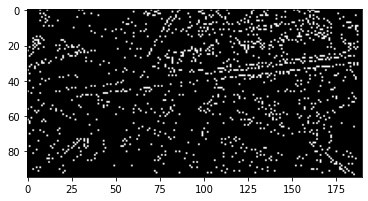

In [10]:
def show_true_tiles(tile_info=tile_info):
    # show labeled tiles
    num_ver = int(tile_info[:,0].max()) + 1
    num_hor = int(tile_info[:,1].max()) + 1
    tiles_show = tile_info[:,2].reshape(num_ver, num_hor)
    print(f"The shape of the tiled picture is {tiles_show.shape}")
    print(f"{tile_info[:,2].sum()} tiles are labeled as trees.")
    plt.imshow(tiles_show, cmap='gray')

show_true_tiles()

Tile: 4370
The tile (top-left edge) is located at pixels 590.0 x 15.0
Column: 0.0, Row: 23.0
label: 1.0  // prediction: 0.22509309649467468
--- The inner line shows the small tile for the classification.
--- The outer, dotted line shows the large tile for the training.
--- The image line shows also adjacent tiles.
--- The dark dot shows the original label pixel.
--- The light dot shows the predicted pixel.


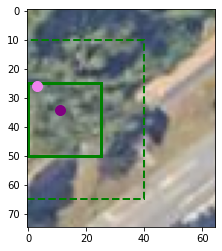

'A random tile with tree is: 13987'

In [206]:
# show image frame around target tile
def show_target_tile(target=None, image=image, tile_info=tile_info, tile_size=tile_size, border=border, pred_pos_tiles=pred_pos_tiles, pos_list=pos_list):

    # choose target tile
    example = random.randint(0, len(tile_info)-1)
    if target is None: target = example
    else: target = target

    # prepare variables
    v_min = int(np.array([tile_info[target,4] - 1 * tile_size]))
    v_max = int(v_min + 3 * tile_size)
    h_min = int(np.array([tile_info[target,5] - 1 * tile_size]))
    h_max = int(h_min + 3 * tile_size)
    h_frame = tile_size # starting pixel of frame
    v_frame = tile_size

    # adjust for image borders
    if v_min < 0:
        v_min = 0
        v_frame = 0
    if h_min < 0:
        h_min = 0
        h_frame = 0
    if h_max > image.shape[1]:
        h_max = image.shape[1]
    if v_max > image.shape[0]:
        v_max = image.shape[0]

    # print info
    print(f"Tile: {target}")
    print(f"The tile (top-left edge) is located at pixels {tile_info[target,4]} x {tile_info[target,5]}")
    print(f"Column: {tile_info[target,1]}, Row: {tile_info[target,0]}")
    print(f"label: {tile_info[target,2]}  // prediction: {tile_info[target,3]}")

    # show image and frame around target tile
    image_partial = image[v_min:v_max, h_min:h_max, :]

    if tile_info[target,2] == 1: color = "green"
    else : color = "red"

    rect = patches.Rectangle(
        (h_frame, v_frame), tile_size, tile_size,
        linewidth=3, edgecolor=color, facecolor='none')
    rect_border = patches.Rectangle(
        (h_frame-border, v_frame-border),
        tile_size + 2 * border, tile_size + 2 * border,
        linewidth=2, edgecolor=color, facecolor='none', linestyle='dashed')

    # show labeled and predicted pixel
    if tile_info[target,2] == 1:
        num_pixel = np.where(pos_list == target)
        plt.plot(h_frame + tile_info[target,6], v_frame + tile_info[target,7], marker='o', color="violet", markersize=10)
        plt.plot(h_frame + pred_pos_tiles[num_pixel,0] - border,
                 v_frame + pred_pos_tiles[num_pixel,1] - border,
                 marker='o', color="purple", markersize=10)

    plt.imshow(image_partial)
    ax = plt.gca()
    ax.add_patch(rect)
    ax.add_patch(rect_border)
    print("--- The inner line shows the small tile for the classification.")
    print("--- The outer, dotted line shows the large tile for the training.")
    print("--- The image line shows also adjacent tiles.")
    print("--- The dark dot shows the original label pixel.")
    print("--- The light dot shows the predicted pixel.")
    plt.show()
    plt.close()
    pass

show_target_tile(target=rand_pos)

rand_pos = pos_list[np.random.randint(0, len(pos_list))]
(f"A random tile with tree is: {rand_pos}")

## Prepare training and validation set

In [152]:
def make_train_set(tiles=tiles_large, tile_labels=tile_labels, tile_size=(tile_size + 2 * border), batch_size=batch_size):
    # define the training set
    train_ratio = 0.8
    num_tiles = tile_labels.shape[0]
    num_train_tiles = int(num_tiles * train_ratio)
    num_val_tiles = num_tiles - num_train_tiles
    print(f"There are {num_tiles} tiles in total.")
    print(f"There are {num_train_tiles} tiles in the training set.")
    print(f"There are {num_val_tiles} tiles in the validation set.")

    # split into training and validation set
    train_tiles = tiles[:int(num_tiles*train_ratio)]
    train_labels = tile_labels[:int(num_tiles*train_ratio)]
    val_tiles = tiles[int(num_tiles*train_ratio):]
    val_labels = tile_labels[int(num_tiles*train_ratio):]
    print(f"Training set: {train_tiles.shape} - ({train_ratio} share of all tiles)")
    print(f"Validation set: {val_tiles.shape}")

    # build tensorflow dataset
    dataset_train_original = tf.data.Dataset.from_tensor_slices((train_tiles, train_labels))
    dataset_validate_original = tf.data.Dataset.from_tensor_slices((val_tiles, val_labels))

    # shuffle and batch
    def encode(tile, label):
        image_encoded = tf.image.convert_image_dtype(tile, dtype=tf.float32)
        image_encoded = tf.image.resize(image_encoded, (tile_size, tile_size))
        return image_encoded, label

    dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache().shuffle(2500).batch(batch_size)
    dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache().batch(batch_size)

    return dataset_train, dataset_validate

dataset_train, dataset_validate = make_train_set()

There are 18050 tiles in total.
There are 14440 tiles in the training set.
There are 3610 tiles in the validation set.
Training set: (14440, 55, 55, 3) - (0.8 share of all tiles)
Validation set: (3610, 55, 55, 3)


-------
# Training

----



## model


In [13]:
def make_model_base(tile_size=(tile_size + 2 * border)):

    METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      #tf.keras.metrics.AUC(name='auc'),
      #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
    initializer = tf.keras.initializers.GlorotUniform(seed=42)

    model = models.Sequential()

    model.add(layers.Input(shape=(tile_size, tile_size, 3)))
    model.add(layers.Conv2D(20, (3,3), activation="relu", padding="same"))
    model.add(layers.Conv2D(30, (3,3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(150, activation="relu"))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid", kernel_initializer=initializer))
    model.summary()

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer="adam",
        metrics=METRICS,

        )
    return model, METRICS

model, METRICS = make_model_base()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 20)        560       
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 30)        5430      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 30)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 21870)             0         
                                                                 
 dense (Dense)               (None, 150)               3280650   
                                                                 
 dense_1 (Dense)             (None, 20)                3020      
                                                        

## Train the tile identification model

In [14]:
def train_model(model_name="latest", model=model, dataset_train=dataset_train, dataset_validate=dataset_validate, epochs=5):

    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_validate,
    )
    model.save(model_name)
    return model, history, model_name

model, history, model_name = train_model(model_name="model_base_6")

Epoch 1/5
49/49 [==============================] - 39s 773ms/step - loss: 0.2707 - binary_accuracy: 0.9123 - precision: 0.1007 - recall: 0.0131 - val_loss: 0.1833 - val_binary_accuracy: 0.9510 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
49/49 [==============================] - 37s 759ms/step - loss: 0.2289 - binary_accuracy: 0.9204 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1438 - val_binary_accuracy: 0.9512 - val_precision: 0.6000 - val_recall: 0.0169
Epoch 3/5
49/49 [==============================] - 36s 725ms/step - loss: 0.1960 - binary_accuracy: 0.9223 - precision: 0.5625 - recall: 0.1019 - val_loss: 0.1579 - val_binary_accuracy: 0.9526 - val_precision: 0.5395 - val_recall: 0.2316
Epoch 4/5
49/49 [==============================] - 35s 715ms/step - loss: 0.1852 - binary_accuracy: 0.9278 - precision: 0.6316 - recall: 0.2195 - val_loss: 0.1381 - val_binary_accuracy: 0.9546 - val_precision: 0.6667 - val_recall: 0.1469
Epoch 5/5
49/49 [===============

INFO:tensorflow:Assets written to: model_base_6/assets


INFO:tensorflow:Assets written to: model_base_6/assets


In [15]:
def render_history(history=history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["precision"], label="precision")
    plt.plot(history["val_precision"], label="val_precision")
    plt.legend()
    plt.title("Our precision")
    plt.show()
    plt.close()
    pass

def compare_histories(history_list=history_list):
    for training_name, history in history_list.items():
        plt.plot(history["val_binary_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()
    pass

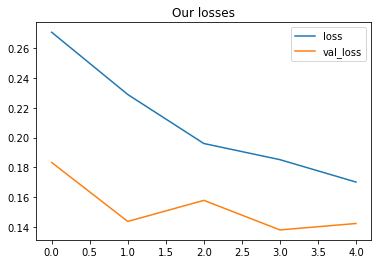

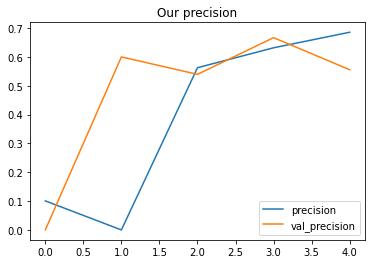

In [16]:
render_history(history.history)

In [17]:
model.save("model_base_6")

INFO:tensorflow:Assets written to: model_base_6/assets


INFO:tensorflow:Assets written to: model_base_6/assets


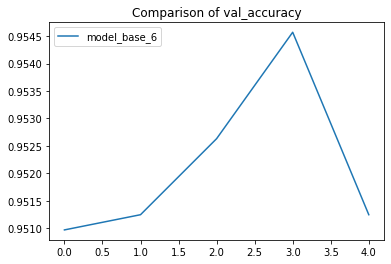

In [18]:
history_list[model_name] = history.history
compare_histories()
tf.keras.backend.clear_session()

-------------------------
# Predict

-----

## predict on training data

In [19]:
# load model
model_tiling = tf.keras.models.load_model("model_base_6")

In [21]:
# predict
threshold_identifying = 0.2
probabilities = model_tiling.predict(tiles_large)
predictions = [1 if x >= threshold_identifying else 0 for x in probabilities]
predictions = np.array(predictions)
# The tiles_info stores: vertical_index, horizontal_index, true label, probability, hor_mean, ver_mean
tile_info[:,3] = probabilities[:,0]

565/565 [==============================] - 8s 13ms/step


In [17]:
# save predictions
np.savetxt(f'prediction_{name_raw_data}_{model_name}.txt', predictions)

In [22]:
def perf_measure(y_actual=tile_info[:,2], y_hat=predictions):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    num_tiles = len(y_actual)
    print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")
    print(f"TP: {int(TP/num_tiles*100)}%,  FP: {int(FP/num_tiles*100)}%,  TN: {int(TN/num_tiles*100)}%,  FN: {int(FN/num_tiles*100)}%")
    return(TP, FP, TN, FN)

TP, FP, TN, FN = perf_measure()


TP: 506, FP: 296, TN: 16429, FN: 819
TP: 2%,  FP: 1%,  TN: 91%,  FN: 4%


802 out of 18050 tiles we predicted as with trees!
This is 0.00044432132963988924% of the tiles


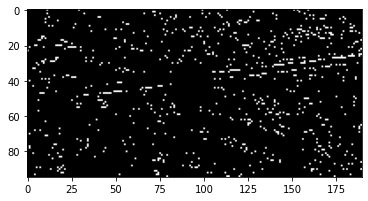

In [23]:
def show_pred_tiles(predictions=predictions, tile_info=tile_info):
    # show prediction of tiles
    num_ver = int(tile_info[:,0].max()) + 1
    num_hor = int(tile_info[:,1].max()) + 1
    tiles_show = predictions.reshape(num_ver, num_hor)
    plt.imshow(tiles_show, cmap='gray')
    num_pos = predictions.sum()
    print(f"{num_pos} out of {len(predictions)} tiles we predicted as with trees!")
    print(f"This is {num_pos / len(predictions)/100}% of the tiles")
    pass

show_pred_tiles()

802 trees identified


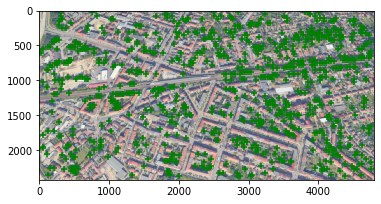

In [24]:
def show_img_with_pred_tile(tile_info=tile_info, threshold=threshold_identifying, image=orig_image, tile_size=tile_size):
    plt.imshow(image)
    pred_pixels = [] # list of pixels of identified trees
    for tree in tile_info:
        if tree[3] >= threshold:
            plt.scatter(tree[5]+(0.5*tile_size), tree[4]+(0.5*tile_size), marker='+',  c="green")
            pred_pixels.append((tree[5], tree[4]))
    print(f"{len(pred_pixels)} trees identified")
    plt.show()
    plt.close()
    return

show_img_with_pred_tile()

----
# Pixel positioning

----

In [150]:
def make_positioning_labels(tile_info=tile_info):

    # make the labels for positioning training
    tile_labels_pos = np.array([tile_info[:,6], tile_info[:,7]]).T
    for tile in tile_labels_pos:
        if tile[0]==0 and tile[1]==0:
            pass
        else: tile += border

    return tile_labels_pos

tile_labels_pos = make_positioning_labels()

In [151]:
def make_train_set_positioning(
        tiles=tiles_large, tile_labels=tile_labels_pos,
        tile_size=(tile_size + 2 * border), batch_size=batch_size):

    print(f"Number of all initial tiles: {len(tiles)}")
    print(f"Shape of tiles: {tiles.shape}")
    print(f"Shape of tile_labels: {tile_labels.shape}\n")

    #Toss tiles without labels (no trees in the tiles)
    pos_labels = []
    pos_tiles = []
    pos_list = []

    for item in range(len(tile_labels[:,0])):
        if np.all(tile_labels[item]!=(0, 0)):
            pos_labels.append(tile_labels_pos[item,:])
            pos_tiles.append(tiles_large[item,:])
            # this list contains reference to original tile :
            pos_list.append(item)

    pos_tiles = np.array(pos_tiles)
    pos_labels = np.array(pos_labels)
    pos_list = np.array(pos_list)

    # define the training set
    train_ratio = 0.8
    num_tiles = len(pos_tiles[:,0])
    num_train_tiles = int(num_tiles * train_ratio)
    num_val_tiles = num_tiles - num_train_tiles
    print(f"Tiles with tree-coordinates for positioning: {num_tiles}")
    print(f"There are {num_train_tiles} tiles in the training set.")
    print(f"There are {num_val_tiles} tiles in the validation set.")

    # split into training and validation set
    train_tiles = tiles[:int(num_tiles*train_ratio)]
    train_labels = tile_labels[:int(num_tiles*train_ratio)]
    val_tiles = tiles[int(num_tiles*train_ratio):]
    val_labels = tile_labels[int(num_tiles*train_ratio):]
    print(f"Training set: {train_tiles.shape} - ({train_ratio} share of all tiles)")
    print(f"Validation set: {val_tiles.shape}")

    # build tensorflow dataset
    dataset_train_original = tf.data.Dataset.from_tensor_slices((train_tiles, train_labels))
    dataset_validate_original = tf.data.Dataset.from_tensor_slices((val_tiles, val_labels))

    # shuffle and batch
    def encode(tile, label):
        image_encoded = tf.image.convert_image_dtype(tile, dtype=tf.float32)
        image_encoded = tf.image.resize(image_encoded, (tile_size, tile_size))
        return image_encoded, label

    dataset_train_pos = dataset_train_original.map(lambda image, label: encode(image, label)).cache().shuffle(250).batch(batch_size)
    dataset_validate_pos = dataset_validate_original.map(lambda image, label: encode(image, label)).cache().batch(batch_size)

    return dataset_train_pos, dataset_validate_pos, pos_labels, pos_tiles, pos_list

dataset_train_pos, dataset_validate_pos, pos_labels, pos_tiles, pos_list = make_train_set_positioning()

Number of all initial tiles: 18050
Shape of tiles: (18050, 55, 55, 3)
Shape of tile_labels: (18050, 2)

Tiles with tree-coordinates for positioning: 1322
There are 1057 tiles in the training set.
There are 265 tiles in the validation set.
Training set: (1057, 55, 55, 3) - (0.8 share of all tiles)
Validation set: (16993, 55, 55, 3)


2022-06-11 01:33:10.022227: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1233691800 exceeds 10% of free system memory.


## model Image Regression with AutoKeras

In [27]:
# load autokeras base model for positioning
model_positioning = tf.keras.models.load_model('autokeras_positioning_regressor.h5')

In [81]:
# Predict with the best model.
pred_pos_tiles = model_positioning.predict(pos_tiles)
print(pred_pos_tiles.shape)
print(pred_pos_tiles)
# Evaluate the best model with testing data.
print(model_positioning.evaluate(pos_tiles, pos_labels))

42/42 [==============================] - 6s 132ms/step
(1322, 2)
[[24.236565 27.528542]
 [23.485817 29.660656]
 [24.25388  28.016361]
 ...
 [22.833853 28.513338]
 [28.125124 26.993134]
 [25.17227  25.036879]]
42/42 [==============================] - 5s 120ms/step - loss: 43.5762 - mse: 43.5762
[43.57615280151367, 43.57615280151367]


In [106]:
def make_pixels_predicted(
        pos_list=pos_list, pred_pos_tiles=pred_pos_tiles,
        tile_info=tile_info, border=border):

    # tile border must not be removed               (-border)
    # because it is not incl. in tile_info position
    pixels_pred = np.array(pred_pos_tiles)

    # Adjust the predicted coordinates to the original image
    for pixel in range(len(pos_list)):
        tile_num = pos_list[pixel]
        pixels_pred[pixel,0] += tile_info[tile_num,4] - border
        pixels_pred[pixel,1] += tile_info[tile_num,5] - border

    pixels_pred =  pixels_pred.astype(int)

    return pixels_pred

pixels_pred = make_pixels_predicted()

Number of predicted pixels: 1322


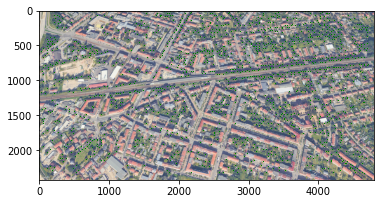

In [108]:
def show_img_with_pixels(image=orig_image, pixels=pixels_pred, marker=','):

    plt.imshow(image)
    # plot each labeled pixel
    for pixel in pixels:
        plt.plot(pixel[1], pixel[0], marker=marker, color="green", )

    print(f"Number of predicted pixels: {len(pixels)}")

    plt.show()

show_img_with_pixels()

Original labels are green   // There are 1383 labels.
Predicted pixels are red   // There are 1322 pixels.


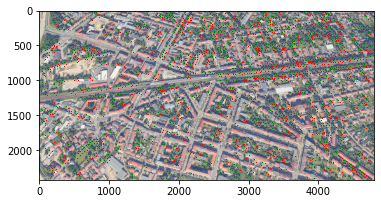

In [105]:
def show_img_pixels_labels(image=orig_image, pixels=pixels_pred, labels=labels, marker=','):

    plt.imshow(image)
    print(f"Original labels are green   // There are {len(labels)} labels.")
    print(f"Predicted pixels are red   // There are {len(pixels)} pixels.")

    # plot each original label
    for dot in labels:
        #print(dot[:,1])
        plt.plot(dot[:,1], dot[:,0], marker=marker, color="green")

    # plot each positioned pixel
    for pixel in pixels:
        plt.plot(int(pixel[1]), int(pixel[0]), marker=marker, color="red", )

    plt.show()

show_img_pixels_labels()